# Time-series data with History and HistoryDict

NetKet provides powerful classes for storing and managing time-series data through the {class}`netket.utils.history.History` and {class}`netket.utils.history.HistoryDict` classes. These are particularly useful for tracking optimization progress, storing simulation results, and managing logging data.

This tutorial will show you how to:
1. Create and manipulate {class}`~netket.utils.history.History` objects
2. Use {class}`~netket.utils.history.HistoryDict` for managing multiple time-series
3. Save and load history data
4. Use logging utilities like {class}`~netket.logging.RuntimeLog` for easy data collection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import os

import netket as nk
from netket.utils import history
from netket.logging import RuntimeLog

## Working with History Objects

The {class}`~netket.utils.history.History` class is designed to store time-series data with associated iteration numbers. Let's start with basic usage:

In [2]:
# Create an empty history object
hist = history.History()
print(f"Empty history: {hist}")
print(f"Length: {len(hist)}")

Empty history: History(keys=['value'], n_iters=0)
Length: 0


### Building History Objects in a Loop

{class}`~netket.utils.history.History` objects are designed to be built incrementally, which is perfect for optimization loops:

In [3]:
# Simulate an optimization loop with data
steps = list(range(10))
energies = [1.0 * np.exp(-step * 0.2) + 0.1 * np.random.randn() for step in steps]

# Create History object with initial data
energy_history = history.History({'energy': energies}, iters=steps)

print(f"History after creation: {energy_history}")
print(f"Iterations: {energy_history.iters}")
print(f"Energy values: {energy_history['energy']}")

History after creation: History(keys=['energy'], n_iters=10)
Iterations: [0 1 2 3 4 5 6 7 8 9]
Energy values: [1.05901467 1.07698539 0.64250923 0.59448121 0.62322185 0.33553292
 0.31330107 0.14264381 0.31478527 0.11293369]


### Plotting History Data

{class}`~netket.utils.history.History` objects have built-in plotting capabilities:

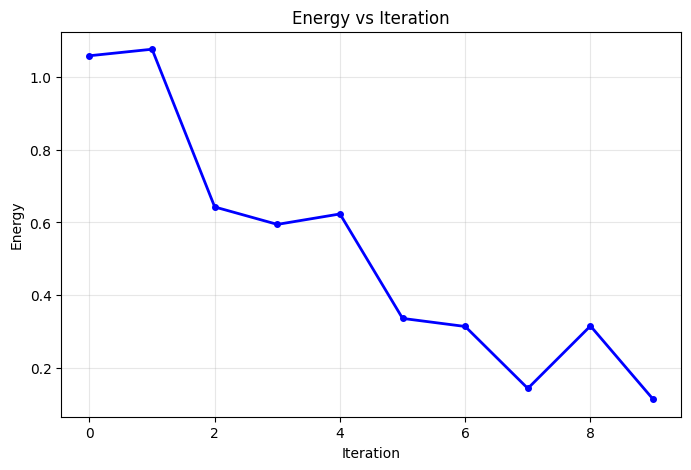

In [4]:
# Plot the energy history manually
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(energy_history.iters, energy_history['energy'], 'b-o', linewidth=2, markersize=4)
ax.set_xlabel('Iteration')
ax.set_ylabel('Energy')
ax.set_title('Energy vs Iteration')
ax.grid(True, alpha=0.3)
plt.show()

### Creating History with Multiple Keys

A single {class}`~netket.utils.history.History` object can store multiple time-series with the same time axis:

In [5]:
# Create a history with multiple metrics
steps = list(range(15))
energies = [1.0 * np.exp(-step * 0.1) + 0.05 * np.random.randn() for step in steps]
variances = [0.5 * np.exp(-step * 0.05) + 0.02 * np.random.randn() for step in steps]
grad_norms = [2.0 * np.exp(-step * 0.3) + 0.1 * np.random.randn() for step in steps]

multi_history = history.History({
    'energy': energies,
    'variance': variances,
    'gradient_norm': grad_norms
}, iters=steps)

print(f"Multi-metric history: {multi_history}")
print(f"Keys: {multi_history.keys()}")

Multi-metric history: History(keys=['energy', 'variance', 'gradient_norm'], n_iters=15)
Keys: ['energy', 'variance', 'gradient_norm']


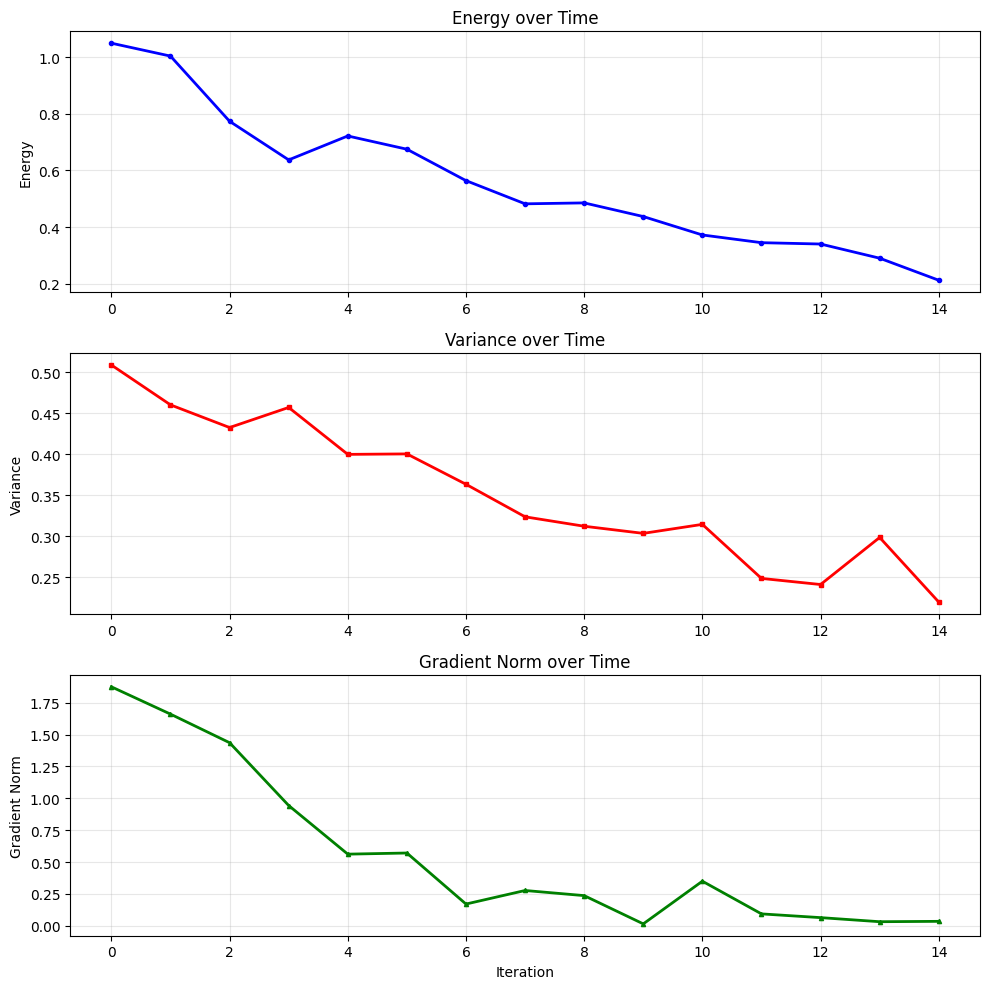

In [6]:
# Plot all metrics manually
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Plot each metric
axes[0].plot(multi_history.iters, multi_history['energy'], 'b-o', linewidth=2, markersize=3, label='Energy')
axes[0].set_ylabel('Energy')
axes[0].set_title('Energy over Time')
axes[0].grid(True, alpha=0.3)

axes[1].plot(multi_history.iters, multi_history['variance'], 'r-s', linewidth=2, markersize=3, label='Variance')
axes[1].set_ylabel('Variance')
axes[1].set_title('Variance over Time')
axes[1].grid(True, alpha=0.3)

axes[2].plot(multi_history.iters, multi_history['gradient_norm'], 'g-^', linewidth=2, markersize=3, label='Gradient Norm')
axes[2].set_ylabel('Gradient Norm')
axes[2].set_xlabel('Iteration')
axes[2].set_title('Gradient Norm over Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Concatenating History Objects

You can concatenate {class}`~netket.utils.history.History` objects together:

In [7]:
# Create two separate history segments with working data
steps1 = list(range(5))
loss1 = [2.0 - step * 0.2 for step in steps1]
hist1 = history.History({'loss': loss1}, iters=steps1)

steps2 = list(range(5, 10))
loss2 = [2.0 - step * 0.2 for step in steps2]
hist2 = history.History({'loss': loss2}, iters=steps2)

print(f"First segment: {hist1}")
print(f"Second segment: {hist2}")

# Concatenate
hist1.append(hist2)
print(f"Concatenated: {hist1}")

First segment: History(keys=['loss'], n_iters=5)
Second segment: History(keys=['loss'], n_iters=5)
Concatenated: History(keys=['loss'], n_iters=10)


## Working with HistoryDict

{class}`~netket.utils.history.HistoryDict` is a powerful container that can store multiple {class}`~netket.utils.history.History` objects or nested dictionaries. Each value can be logged at independent iterations, making it perfect for complex simulations where different metrics are computed at different frequencies.

### Using accum_histories_in_tree for HistoryDict Construction

The {func}`~netket.utils.history.accum_histories_in_tree` function is the recommended way to build complex nested history structures:

In [8]:
# Start with an empty HistoryDict
history_dict = history.HistoryDict()

# Simulate a complex optimization with nested metrics
for step in range(20):
    # Core metrics computed every step
    data = {
        'energy': -2.0 + 0.1 * np.random.randn(),
        'variance': 0.5 + 0.05 * np.random.randn()
    }
    
    # Expensive metrics computed every 5 steps
    if step % 5 == 0:
        data['expensive_metrics'] = {
            'correlation_length': 2.0 + 0.2 * np.random.randn(),
            'entanglement_entropy': 1.5 + 0.1 * np.random.randn()
        }
    
    # Diagnostic metrics computed every 3 steps
    if step % 3 == 0:
        data['diagnostics'] = {
            'acceptance_rate': 0.5 + 0.1 * np.random.randn(),
            'step_size': 0.01 + 0.001 * np.random.randn()
        }
    
    # Use accum_histories_in_tree to accumulate the data
    history_dict = history.accum_histories_in_tree(history_dict, data, step=step)

print(f"Complex HistoryDict: {history_dict}")

Complex HistoryDict: HistoryDict with 6 elements:
	'diagnostics/acceptance_rate' -> History(keys=['value'], n_iters=7)
	'diagnostics/step_size' -> History(keys=['value'], n_iters=7)
	'energy' -> History(keys=['value'], n_iters=20)
	'expensive_metrics/correlation_length' -> History(keys=['value'], n_iters=4)
	'expensive_metrics/entanglement_entropy' -> History(keys=['value'], n_iters=4)
	'variance' -> History(keys=['value'], n_iters=20)


### Accessing Data in HistoryDict

{class}`~netket.utils.history.HistoryDict` supports various ways to access nested data:

In [9]:
# Access top-level keys
print(f"Top-level keys: {list(history_dict.keys())}")

# Access nested data using dictionary syntax
print(f"Energy history: {history_dict['energy']}")
print(f"Expensive metrics: {history_dict['expensive_metrics']}")

# Access deeply nested data using path syntax
correlation_history = history_dict['expensive_metrics/correlation_length']
print(f"Correlation length history: {correlation_history}")

# Show that different metrics were logged at different frequencies
print(f"Energy logged at steps: {history_dict['energy'].iters}")
print(f"Correlation length logged at steps: {correlation_history.iters}")
print(f"Acceptance rate logged at steps: {history_dict['diagnostics/acceptance_rate'].iters}")

Top-level keys: ['energy', 'variance', 'expensive_metrics', 'diagnostics']
Energy history: History(keys=['value'], n_iters=20)
Expensive metrics: HistoryDict with 2 elements:
	'correlation_length' -> History(keys=['value'], n_iters=4)
	'entanglement_entropy' -> History(keys=['value'], n_iters=4)
Correlation length history: History(keys=['value'], n_iters=4)
Energy logged at steps: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Correlation length logged at steps: [ 0  5 10 15]
Acceptance rate logged at steps: [ 0  3  6  9 12 15 18]


### Plotting Data from HistoryDict

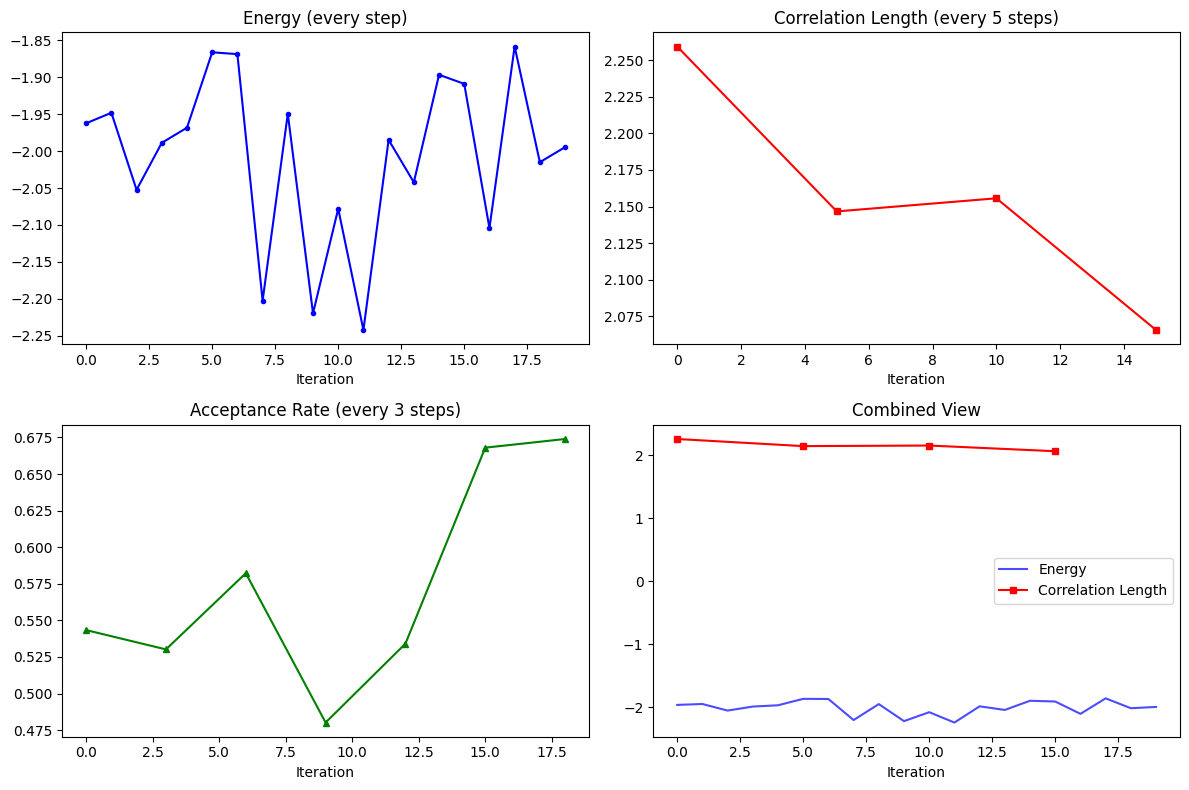

In [10]:
# Plot different metrics with different sampling frequencies
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Energy (every step)
axes[0, 0].plot(history_dict['energy'].iters, history_dict['energy'].values, 'b-o', markersize=3)
axes[0, 0].set_title('Energy (every step)')
axes[0, 0].set_xlabel('Iteration')

# Correlation length (every 5 steps)
corr_hist = history_dict['expensive_metrics/correlation_length']
axes[0, 1].plot(corr_hist.iters, corr_hist.values, 'r-s', markersize=5)
axes[0, 1].set_title('Correlation Length (every 5 steps)')
axes[0, 1].set_xlabel('Iteration')

# Acceptance rate (every 3 steps)
acc_hist = history_dict['diagnostics/acceptance_rate']
axes[1, 0].plot(acc_hist.iters, acc_hist.values, 'g-^', markersize=4)
axes[1, 0].set_title('Acceptance Rate (every 3 steps)')
axes[1, 0].set_xlabel('Iteration')

# Combined plot
axes[1, 1].plot(history_dict['energy'].iters, history_dict['energy'].values, 'b-', alpha=0.7, label='Energy')
axes[1, 1].plot(corr_hist.iters, corr_hist.values, 'r-s', markersize=4, label='Correlation Length')
axes[1, 1].set_title('Combined View')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Saving and Loading HistoryDict

{class}`~netket.utils.history.HistoryDict` provides convenient methods for saving and loading data:

In [11]:
# Create a temporary file for demonstration
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as tmp_file:
    tmp_filename = tmp_file.name

print(f"Saving to temporary file: {tmp_filename}")

# Save the HistoryDict - we'll use RuntimeLog for this
# (HistoryDict itself doesn't have a direct save method, but RuntimeLog does)
runtime_log = RuntimeLog()
runtime_log._data = history_dict
runtime_log.serialize(tmp_filename)

print("Data saved successfully!")

Saving to temporary file: /var/folders/b_/dvph1c6569155bspz2m2sml40000gp/T/tmpnfskv9xu.json
Data saved successfully!


In [12]:
# Load the data back
loaded_history_dict = history.HistoryDict.from_file(tmp_filename)

print(f"Loaded HistoryDict: {loaded_history_dict}")

# Verify the data is the same
print(f"Original energy values: {history_dict['energy'].values[:5]}")
print(f"Loaded energy values: {loaded_history_dict['energy'].values[:5]}")

# Clean up
os.unlink(tmp_filename)

Loaded HistoryDict: HistoryDict with 6 elements:
	'diagnostics/acceptance_rate' -> History(keys=['value'], n_iters=7)
	'diagnostics/step_size' -> History(keys=['value'], n_iters=7)
	'energy' -> History(keys=['value'], n_iters=20)
	'expensive_metrics/correlation_length' -> History(keys=['value'], n_iters=4)
	'expensive_metrics/entanglement_entropy' -> History(keys=['value'], n_iters=4)
	'variance' -> History(keys=['value'], n_iters=20)
Original energy values: [-1.96226202 -1.9480204  -2.05242489 -1.98877341 -1.96826794]
Loaded energy values: [-1.96226202 -1.9480204  -2.05242489 -1.98877341 -1.96826794]


## Using RuntimeLog for Easy Data Collection

The {class}`~netket.logging.RuntimeLog` class provides an even easier way to work with history data. It automatically uses {class}`~netket.utils.history.HistoryDict` internally and provides a simple interface for logging data in loops.

### Basic RuntimeLog Usage

By passing `driver=None` to log in a loop, {class}`~netket.logging.RuntimeLog` becomes a simple and powerful logging tool:

In [13]:
# Create a RuntimeLog instance
log = RuntimeLog()

# Simulate a training loop with irregular logging
for epoch in range(25):
    # Basic metrics every epoch
    metrics = {
        'train_loss': 1.0 * np.exp(-epoch * 0.1) + 0.1 * np.random.randn(),
        'learning_rate': 0.01 * np.exp(-epoch * 0.05)
    }
    
    # Validation metrics every 5 epochs
    if epoch % 5 == 0:
        metrics['validation'] = {
            'val_loss': 1.2 * np.exp(-epoch * 0.08) + 0.15 * np.random.randn(),
            'val_accuracy': 0.5 + 0.4 * (1 - np.exp(-epoch * 0.1))
        }
    
    # Model checkpointing info every 10 epochs
    if epoch % 10 == 0:
        metrics['checkpoint'] = {
            'model_size_mb': 150 + 5 * np.random.randn(),
            'save_time_seconds': 2.5 + 0.5 * np.random.randn()
        }
    
    # Log the metrics (note: driver=None is implicit)
    log(step=epoch, item=metrics, variational_state=None)

print(f"RuntimeLog contents: {log}")
print(f"Available keys: {list(log.data.keys())}")

RuntimeLog contents: RuntimeLog():
 keys = ['train_loss', 'learning_rate', 'validation', 'checkpoint']
Available keys: ['train_loss', 'learning_rate', 'validation', 'checkpoint']


### Accessing RuntimeLog Data

{class}`~netket.logging.RuntimeLog`'s data attribute is a {class}`~netket.utils.history.HistoryDict`, so you can use all the same access patterns:

In [14]:
# Access the underlying HistoryDict
data = log.data
print(f"Type of log.data: {type(data)}")

# Access different metrics
print(f"Train loss history: {data['train_loss']}")
print(f"Validation loss history: {data['validation/val_loss']}")
print(f"Checkpoint info: {data['checkpoint']}")

# Show different logging frequencies
print(f"\nLogging frequencies:")
print(f"Train loss logged at: {len(data['train_loss'].iters)} steps")
print(f"Validation logged at: {len(data['validation/val_loss'].iters)} steps")
print(f"Checkpoints at: {data['checkpoint/model_size_mb'].iters}")

Type of log.data: <class 'netket.utils.history.history_dict.HistoryDict'>
Train loss history: History(keys=['value'], n_iters=25)
Validation loss history: History(keys=['value'], n_iters=5)
Checkpoint info: HistoryDict with 2 elements:
	'model_size_mb' -> History(keys=['value'], n_iters=3)
	'save_time_seconds' -> History(keys=['value'], n_iters=3)

Logging frequencies:
Train loss logged at: 25 steps
Validation logged at: 5 steps
Checkpoints at: [ 0 10 20]


### Plotting RuntimeLog Data

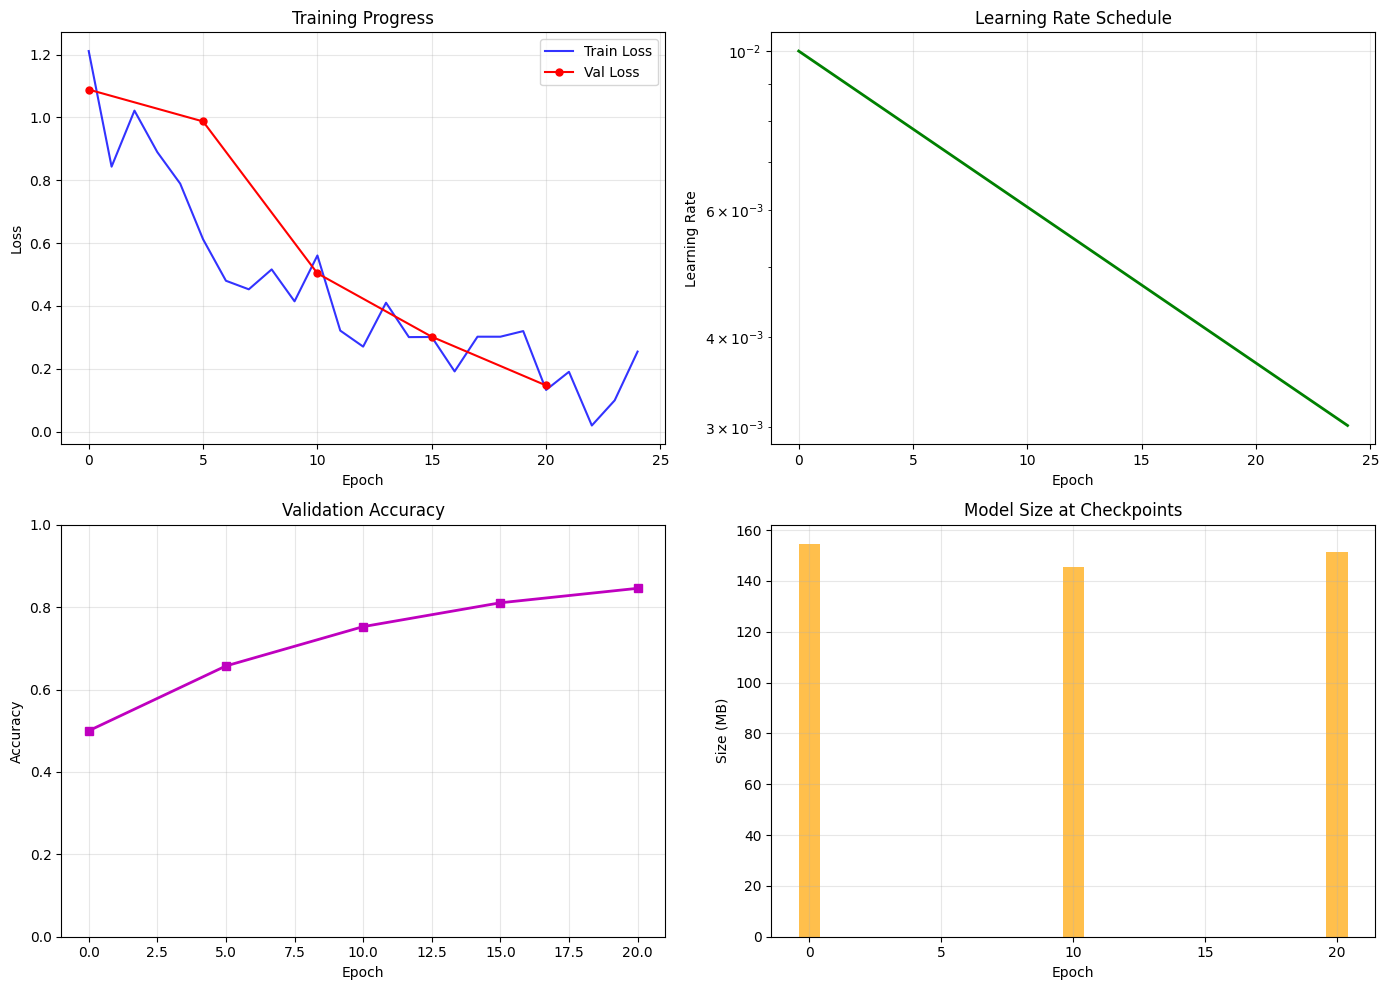

In [15]:
# Create a comprehensive plot of the logged data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training and validation loss
train_loss = data['train_loss']
val_loss = data['validation/val_loss']

axes[0, 0].plot(train_loss.iters, train_loss.values, 'b-', label='Train Loss', alpha=0.8)
axes[0, 0].plot(val_loss.iters, val_loss.values, 'r-o', label='Val Loss', markersize=5)
axes[0, 0].set_title('Training Progress')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Learning rate
lr_hist = data['learning_rate']
axes[0, 1].plot(lr_hist.iters, lr_hist.values, 'g-', linewidth=2)
axes[0, 1].set_title('Learning Rate Schedule')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Validation accuracy
val_acc = data['validation/val_accuracy']
axes[1, 0].plot(val_acc.iters, val_acc.values, 'm-s', markersize=6, linewidth=2)
axes[1, 0].set_title('Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3)

# Model size at checkpoints
model_size = data['checkpoint/model_size_mb']
axes[1, 1].bar(model_size.iters, model_size.values, alpha=0.7, color='orange')
axes[1, 1].set_title('Model Size at Checkpoints')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Size (MB)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Saving and Loading RuntimeLog Data

In [16]:
# Save the RuntimeLog data
with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as tmp_file:
    tmp_filename = tmp_file.name

log.serialize(tmp_filename)
print(f"RuntimeLog data saved to: {tmp_filename}")

# Load it back as a HistoryDict
loaded_data = history.HistoryDict.from_file(tmp_filename)
print(f"Loaded data type: {type(loaded_data)}")
print(f"Loaded keys: {list(loaded_data.keys())}")

# Verify data integrity
original_train_loss = log.data['train_loss'].values
loaded_train_loss = loaded_data['train_loss'].values
print(f"Data integrity check: {np.allclose(original_train_loss, loaded_train_loss)}")

# Clean up
os.unlink(tmp_filename)

RuntimeLog data saved to: /var/folders/b_/dvph1c6569155bspz2m2sml40000gp/T/tmp7ewmq_q8.json
Loaded data type: <class 'netket.utils.history.history_dict.HistoryDict'>
Loaded keys: ['checkpoint', 'learning_rate', 'train_loss', 'validation']
Data integrity check: True
